# Image Classification Boilerplate Comparison

In [1]:
#Imports
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import os
import glob
import random
random.seed(4)
import glob
import shutil
import json

import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim

### The Dataset
- The dataset used in this example is the <a href="http://www.robots.ox.ac.uk/~vgg/data/flowers/102/">Flowers 102 Dataset</a>.
- Run the next cell to download the data from s3, create a new folder and extract the files required.

- The directory structure of the dataset is:

    ```
    ├── small_flowers
        ├── images
            ├── 0
                ├── image_1.jpg
                ├── image_2.jpg
                ├── ...
            ├── 1
                ├── image_3.jpg
                ├── image_4.jpg
                ├── ...
        ├── annotations
            ├── mapping.json
    ```

In [2]:
# The dataset will be downloaded from s3, and extracted into a new folder
!wget https://s-3.s3-eu-west-1.amazonaws.com/small_flowers.zip
!unzip small_flowers.zip

--2020-09-03 13:14:50--  https://s-3.s3-eu-west-1.amazonaws.com/small_flowers.zip
Resolving s-3.s3-eu-west-1.amazonaws.com (s-3.s3-eu-west-1.amazonaws.com)...52.218.96.179
Connecting to s-3.s3-eu-west-1.amazonaws.com (s-3.s3-eu-west-1.amazonaws.com)|52.218.96.179|:443...connected.
HTTP request sent, awaiting response...200 OK
Length: 5580492 (5.3M) [application/zip]
Saving to: ‘small_flowers.zip’

small_flowers.zip   100%[===================>]   5.32M  1.39MB/s    in 4.7s    

2020-09-03 13:14:55 (1.13 MB/s) - ‘small_flowers.zip’ saved [5580492/5580492]

Archive:  small_flowers.zip
   creating: small_flowers/
   creating: small_flowers/images/
   creating: small_flowers/images/1/
  inflating: small_flowers/images/1/image_05109.jpg  
  inflating: small_flowers/images/1/image_05125.jpg  
  inflating: small_flowers/images/1/image_05133.jpg  
  inflating: small_flowers/images/1/image_05100.jpg  
  inflating: small_flowers/images/1/image_05107.jpg  
  inflating: small_flowers/images/1/image

In [3]:
# The path to the folders
path_to_images = "./small_flowers/images"
mapping_json_path = os.path.join("small_flowers/annotations", "mapping.json")

In [17]:
classes_dir = ["0", "1", "2"]

root_dir = "./small_flowers/images"
train_ratio = 0.8
val_ratio = train_ratio # percentage at which validation set starts
test_ratio = val_ratio + 0.1

for label in classes_dir:
    if not os.path.exists(os.path.join(root_dir,  'dataset/train', label)):
        os.makedirs(os.path.join(root_dir, 'dataset/train', label))
        os.makedirs(os.path.join(root_dir, 'dataset/val', label))
        os.makedirs(os.path.join(root_dir, 'dataset/test', label))

        label_folder = os.path.join(root_dir,  label)

        ims = os.listdir(label_folder)
        np.random.shuffle(ims)

        train, val, test = np.split(np.array(ims),
                                [int(len(ims)*(val_ratio)),
                                    int(len(ims)*(test_ratio))])
        train = [os.path.join(label_folder, name) for name in train.tolist()]
        val = [os.path.join(label_folder, name) for name in val.tolist()]
        test = [os.path.join(label_folder, name) for name in test.tolist()]

        for name in train:
            shutil.copy(name, os.path.join(root_dir, 'dataset/train', label))

        for name in val:
            shutil.copy(name, os.path.join(root_dir, 'dataset/val', label))

        for name in test:
            shutil.copy(name, os.path.join(root_dir, 'dataset/test', label))



In [14]:
root_dir = "./small_flowers/images"
train_ratio = 0.8
val_ratio = train_ratio # percentage at which validation set starts
test_ratio = val_ratio + 0.1


im_list = [os.path.abspath(i) for i in glob.glob(root_dir + '/**/*.jpg', recursive=True)]
im_list = random.sample(im_list, len(im_list))

if not os.path.exists(os.path.join(root_dir,  'dataset/train')):
    os.makedirs(os.path.join(root_dir, 'dataset/train'))
    os.makedirs(os.path.join(root_dir, 'dataset/val'))
    os.makedirs(os.path.join(root_dir, 'dataset/test'))

train, val, test = np.split(np.array(im_list),
                        [int(len(im_list)*(val_ratio)),
                            int(len(im_list)*(test_ratio))])
train = [os.path.join(root_dir, name) for name in train.tolist()]
val = [os.path.join(root_dir, name) for name in val.tolist()]
test = [os.path.join(root_dir, name) for name in test.tolist()]

for name in train:
    shutil.copy(name, os.path.join(root_dir, 'dataset/train'))

for name in val:
    shutil.copy(name, os.path.join(root_dir, 'dataset/val'))

for name in test:
    shutil.copy(name, os.path.join(root_dir, 'dataset/test'))

SameFileError: '/home/harsha/Documents/rediscovery/remo-python/examples/small_flowers/images/dataset/train/image_05143.jpg' and './small_flowers/images/dataset/train/image_05143.jpg' are the same file

In [18]:
# Channel wise mean and standard deviation for normalizing according to ImageNet Statistics
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

# Transforms to be applied to Train-Test-Validation
train_transforms = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])

test_valid_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)])

In [19]:
# The JSON file is provided in the dataset, and is then converted into a mapping dictionary.
# cat_to_index : mapping between class_index -> class_label
cat_to_index = { 0 : 'Pink Primrose',  
                 1 : 'Hard-leaved Pocket Orchid', 
                 2 : 'Canterbury Bells'}
# Mapping from Class Name --> Index
mapping = { value : key for (key, value) in cat_to_index.items()}

The train, test and validation datasets are instantiated and wrapped around a ```DataLoader``` method.

In [21]:
images_dir = "./small_flowers/images/dataset"
train_dataset = datasets.ImageFolder(os.path.join(images_dir, "train"), transform = train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(images_dir, "test"), transform = test_valid_transforms)
valid_dataset = datasets.ImageFolder(os.path.join(images_dir, "val"), transform = test_valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=2,  shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1, shuffle=False, num_workers=2)


print("Length of Train Dataset {}".format(len(train_dataset)))
print("Length of Valid Dataset {}".format(len(valid_dataset)))
print("Length of Test Dataset {}".format(len(test_dataset)))


dataloaders = { "train" : train_loader, "valid" : val_loader, "test" : test_loader}

Length of Train Dataset 112
Length of Valid Dataset 14
Length of Test Dataset 14


In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

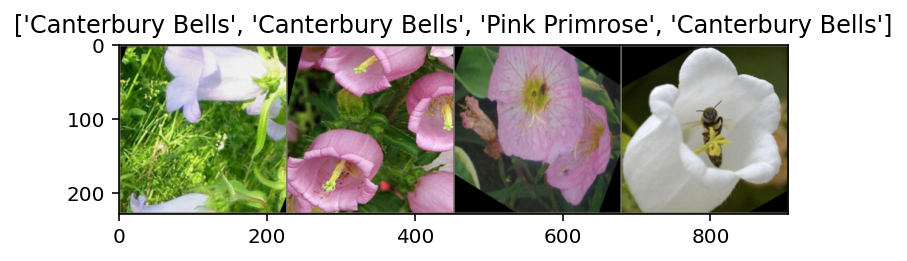

In [35]:
inputs, classes = next(iter(dataloaders['train']))
class_names = train_dataset.classes
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[cat_to_index[int(class_names[x])] for x in classes])

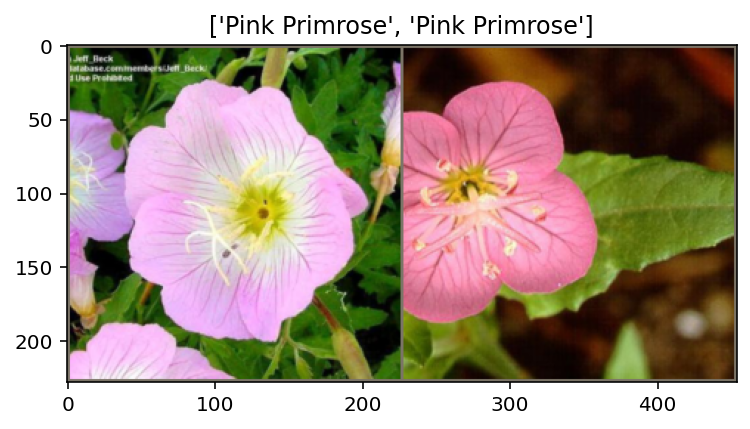

In [36]:
inputs, classes = next(iter(dataloaders['valid']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[cat_to_index[int(class_names[x])] for x in classes])

## Training the Model

The pre-trained weights of the ```ResNet-18``` model with ImageNet are used in this tutorial.

To train the model, the following details are to be specified.

1. **Model:** The edited version of the pre-trained model.
2. **Data Loaders:** The dictionary containing our training and validation dataloaders
3. **Criterion:** The loss function used for training the network
4. **Num_epochs:** The number of epochs for which we would like to train the network.
5. **dataset_size:** an additional parameter which is used to correctly scale the loss, the method for this is specified in the DataLoader cell

In [ ]:
model = models.resnet18(pretrained=True)

# Freezing the weightsresults_view
for param in model.parameters():
    param.required_grad = False


# Replacing the final layer
model.fc = nn.Sequential(nn.Linear(512, 256), 
                         nn.ReLU(), 
                         nn.Dropout(p=0.5), 
                         nn.Linear(256, 102), 
                         nn.LogSoftmax(dim=1))

In [ ]:
# Model Parameters

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.NLLLoss()
num_epochs = 1
dataloaders = { "train" : train_loader, "valid" : val_loader, "test" : test_loader}
dataset_size = {"train" : len(train_dataset), "valid" : len(valid_dataset)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device) # This method pushes the model to the device.


In [ ]:
# The training loop trains the model for the total number of epochs,
# an epoch is one complete pass over the entire dataset
for epoch in range(num_epochs):
    
    model.train() # This sets the model back to training after the validation step
    print("Epoch Number {}".format(epoch))

    training_loss = 0.0
    val_loss = 0.0
    val_acc = 0
    correct_preds = 0
    best_acc = 0
    validation = 0.0
    total = 0

    
    data_loader = tqdm.tqdm(dataloaders["train"])
    for x, y in data_loader:
        inputs, labels = x.to(device), y.to(device)
        outputs = model(inputs)
        optimizer.zero_grad()

        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

        training_loss += loss.item()
    
    epoch_loss = training_loss / dataset_size["train"]

    print("Training Loss : {:.5f}".format(epoch_loss))

    val_data_loader = tqdm.tqdm(dataloaders["valid"])
    
    # Validation step after every epoch
    # The gradients are not required at inference time, hence the model is set to eval mode
    with torch.no_grad():
        model.eval()
        for x, y in val_data_loader:
            inputs, labels = x.to(device), y.to(device)
            outputs = model(inputs)

            val_loss = criterion(outputs, labels)
            _, index = torch.max(outputs, 1)

            total += labels.size(0)
            correct_preds += (index == labels).sum().item()

            validation += val_loss.item()

        val_acc = 100 * (correct_preds / total)

        print("Validation Loss : {:.5f}".format(validation / dataset_size["valid"]))
        print("Validation Accuracy is: {:.2f}%".format(val_acc))
        
        # The model is saved only if current validation accuracy is higher than the previous best accuracy
        if best_acc < val_acc:
            best_acc = val_acc
            model_name = "./saved_model_{:.2f}.pt".format(best_acc)
            torch.save(model, model_name)
            

In [ ]:
def visualize_model(model):
    images_so_far = 0
    fig = plt.figure()

    for inputs, labels in tqdm.tqdm(dataloaders['test']):
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        for j in range(inputs.size()[0]):
            images_so_far += 1
            #ax = plt.subplot(num_images, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.data[j], title='predicted: {} \n original: {}'.format(cat_to_index[class_names[preds[j]]], cat_to_index[class_names[labels[0].item()]]))

In [ ]:
def visualize_model(model):
    images_so_far = 0
    fig = plt.figure()
    predictions = pd.read_csv(predictions)
    ground_truth = pd.read_csv(ground_truth)

    for j in range(len(predictions)):
        images_so_far += 1
        ax.axis('off')
        title= f'predicted: {cat_to_index[class_names[predictions.loc[j, "class_name"]]]} \n original: {cat_to_index[class_names[ground_truth.loc[j, "class_name"]]]}'
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)

## Visualizing Predictions

0%|          | 0/7 [00:00<?, ?it/s]

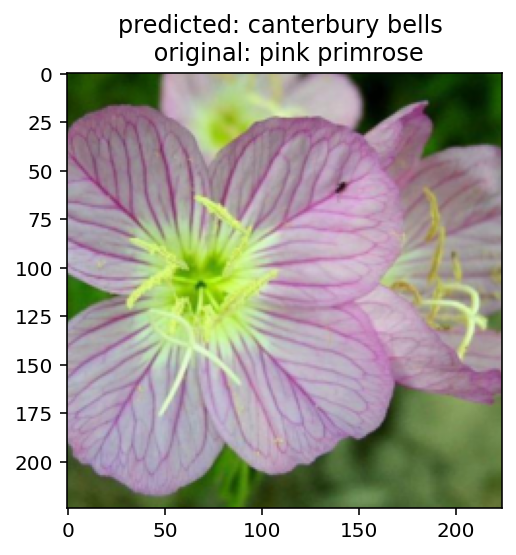

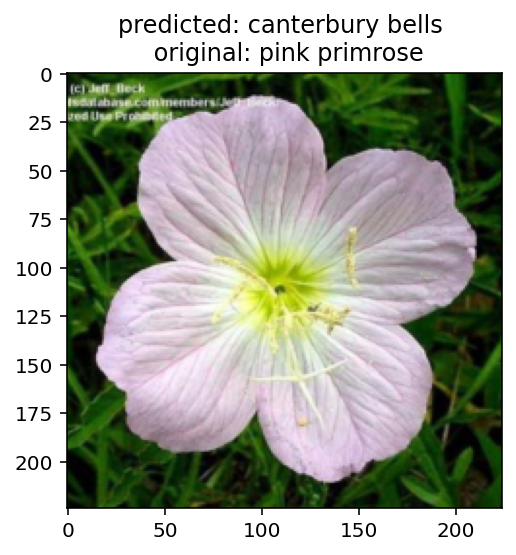

14%|█▍        | 1/7 [00:01<00:06,  1.10s/it]

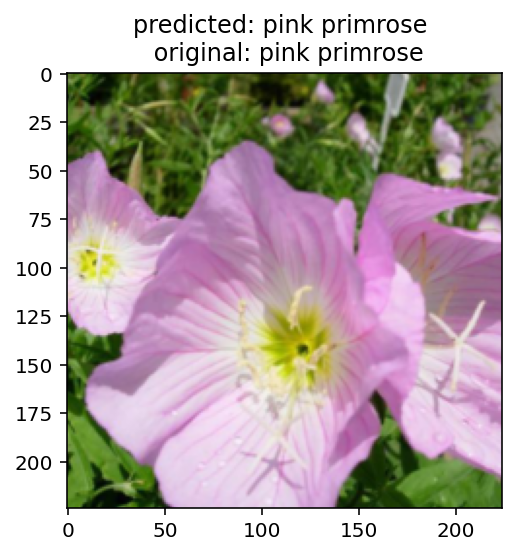

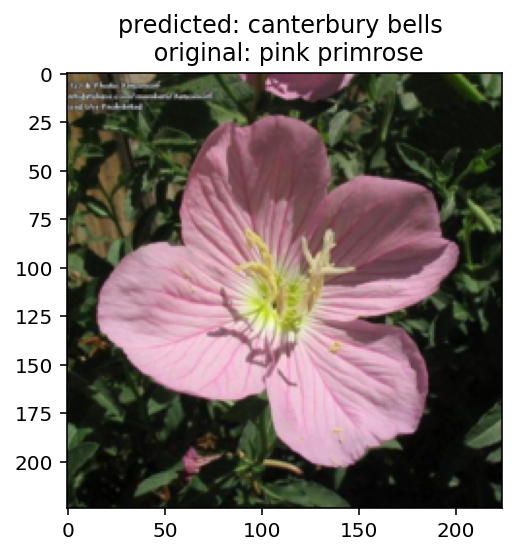

29%|██▊       | 2/7 [00:02<00:05,  1.09s/it]

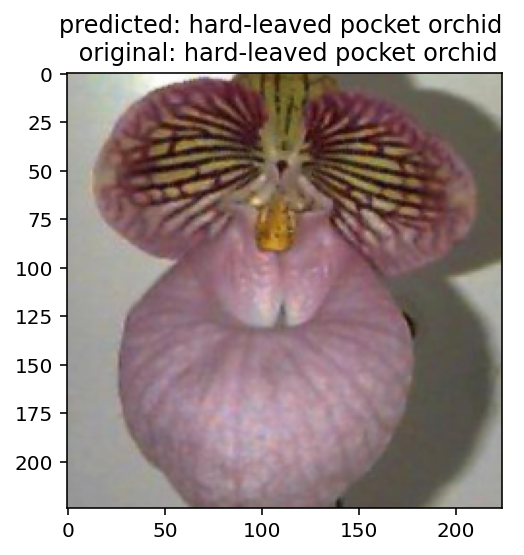

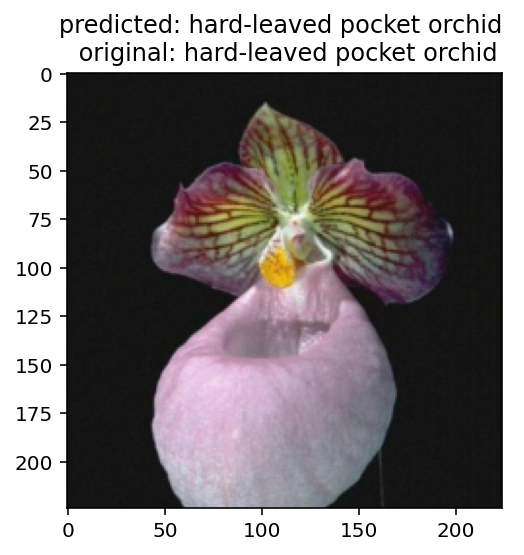

43%|████▎     | 3/7 [00:03<00:04,  1.07s/it]

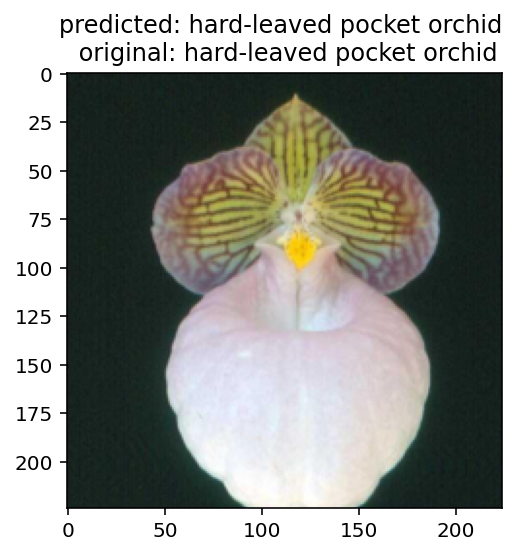

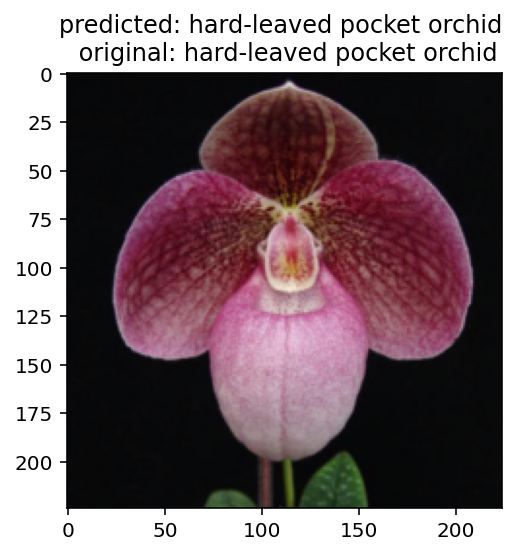

57%|█████▋    | 4/7 [00:04<00:03,  1.04s/it]

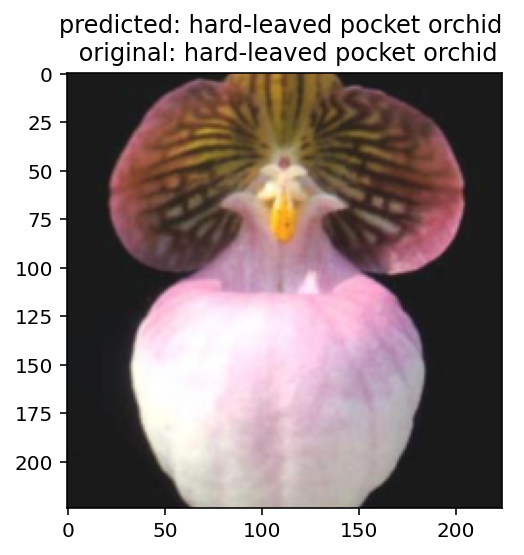

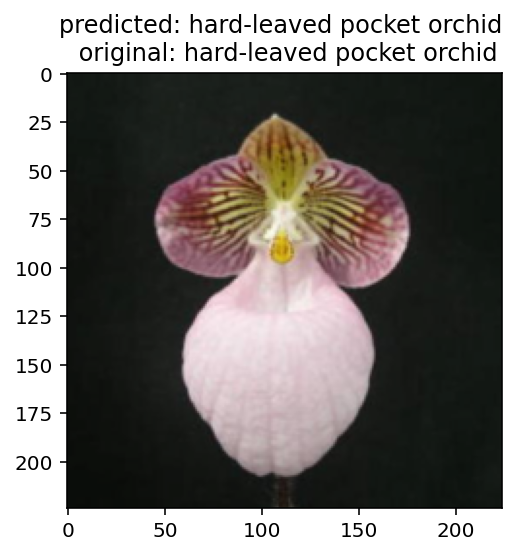

71%|███████▏  | 5/7 [00:05<00:01,  1.00it/s]

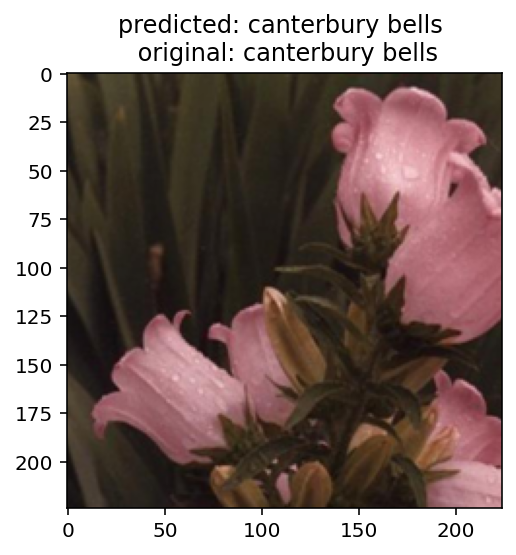

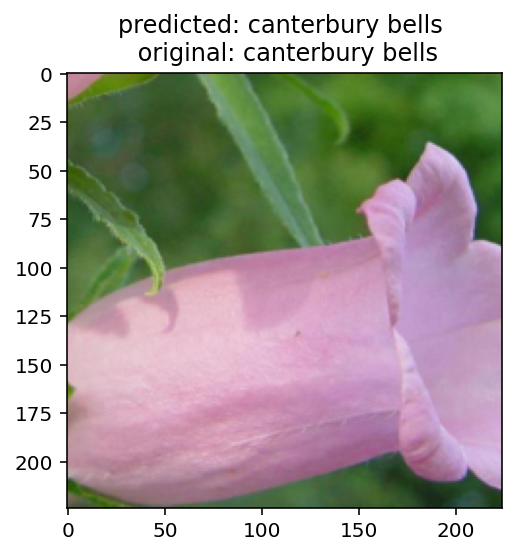

86%|████████▌ | 6/7 [00:06<00:01,  1.01s/it]

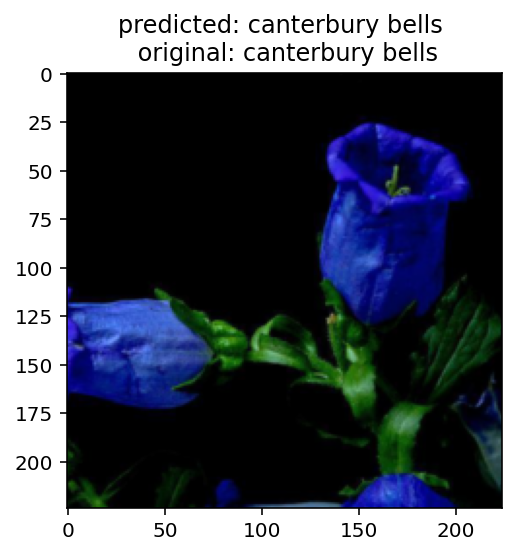

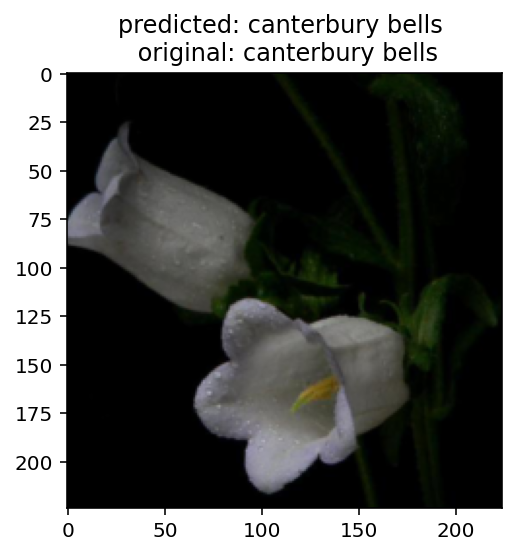

100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


In [120]:
visualize_model(test_model)